
# Statistical Analysis of Maintenance Operations

**Author**: Ricardo Pérez Castillo  

**Date**: 2019-10-25

**Purpose**: Determine what causes a machine to break down sooner rather than later, and what factors influence the cost of the repair

**Keywords**: PCA, maintenance operations, MRO, Deep Learning

## Table of Contents
1. [Introduction](#Introduction)
2. [Data Description](#Data-Description)
3. [Methodology](#Methodology)
4. [Data Exploration](#Data-Exploration)
5. [Data Preprocessing](#Data-Preprocessing)

## Introduction

Manufacturing companies use sophisticated machinery that requires constant service. Records are kept about in-between break down times, time it takes to fix a machine, deviations from expected problem solution time and of course information about what kind of repair was carried out, who did it, where and how much it cost.

Equipment maintenance is one of the main costs that companies must deal with for a profitable operation. The time between breakdowns must be reduced as needs to happen with the time it takes to repair a machine and specifically and the machine repair cost must be minimized.

**Objetive:** In this analysis we aim to determine what causes a machine to break down sooner rather than later, and what factors influence the cost of the repairs. We also aim to give probability bands for machine repair time and in between-time break downs.


## Data Description

The data consists of reports about maintenance of solid waste disposal systems. There are 30 variables in the raw data (parts_filtered.csv) 

The dependent variable is defined as follows:

$$
\text{Class} =
\begin{cases} 
1 & \text{if Cost} > €60,000.00 \\
0 & \text{if Cost} \leq €60,000.00
\end{cases}
$$




Thus the cost variable was eliminated. Originally there were 66,470 samples. The number of samples was reduced/desampled to 17,394 to balance the number of samples belonging to each value of class, as will be explained further below.

## Methodology

I will apply the technique Predictive Factor Association (PFA), designed by Dr. Raul Valente-Ramirez [Scientific Paper](https://link.springer.com/chapter/10.1007/978-3-030-22750-0_28)

The general outline of the technique is the following: 
- We are given a matrix X with data in which rows are samples (𝑚 samples) with numerical values and columns are variables (𝑛 variables).
- The explanatory variables are separated into matrix 𝐸 (𝑜 variables) and the dependent variables (𝑝 variables), or variables of interest, are separated into matrix 𝐷. 
- Furthermore 𝑛 = 𝑜 + 𝑝. 
- Using PCA samples scores and variables loadings, dimension reduction and clustering can be carried out.


Figure 1 shows the steps of the procedure:

https://link.springer.com/chapter/10.1007/978-3-030-22750-0_28/figures/1

## Data Exploration

In [10]:
# Basic Libraries
import numpy as np
from datetime import datetime

# Pandas
import pandas as pd
from pandas import read_csv, DataFrame, concat

# Matplot Lib
import matplotlib.pyplot as plt

In [ ]:
# Read data
dataset = pd.read_csv("parts_filtered.csv")
dataset.head()

,AREA_GEOGRAFICA,PROYECTO,INSTALACION,USUARIO,TIPO_USUARIO,TIPO_ASISTENCIA,EQUIPO,TIPO_EQUIPO,TIPO_FRACCION,TIPO_AVERIA,...,INMERSION,ACOMPANANTE,TRABAJO_FINALIZADO,RED_VERTIDO,ORDEN_TRABAJO,TIPO_ORDEN,TIEMPO_FECHAPREVISTA_FECHAFINALIZACION,HAY_MATERIALES_TEXTO,CANTIDAD_MATERIALES,COSTO
0,4,42,4201,9.0,3,1,0,0,0,3,...,0,0,1,1,515,1,2,0,131,812538
1,4,42,4201,9.0,3,1,0,0,0,3,...,0,0,0,1,516,1,0,0,131,812538
2,4,42,4201,9.0,3,2,5853,5200,0,1,...,0,0,0,1,3188,1,8,0,131,812538
3,4,42,4201,9.0,3,2,5853,5200,0,1,...,0,0,0,1,3217,1,15,0,131,812538
4,4,42,4201,9.0,3,2,5853,5200,0,1,...,0,0,0,1,3218,1,7,0,131,812538


### Summary of Parts Data:

#### Key Features:
- **Breakdown Timing**: Features such as `TIEMPO_ENTRE_EQUIPO_FALLO` and `TIEMPO_ENTRE_FALLO_EQUIPO_AVERIA` could help analyze the frequency of machine breakdowns.
- **Repair Costs**: The `COSTO` field captures the cost of repairs, but we need to transform to binary (0,1)
- **Materials Used**: `CANTIDAD_MATERIALES` provides insight into materials used for repairs and could correlate with costs.
- **Repair Time**: Fields like `TIEMPO_FECHAPREVISTA_FECHAFINALIZACION` and `TIEMPO_TRABAJO` track repair durations.

#### Variables for Analysis:
- **Machine breakdown probability**: Explore `TIEMPO_ENTRE_EQUIPO_FALLO`, `TIPO_FALLO`, and `TIPO_AVERIA`.
- **Repair cost factors**: Analyze `COSTO` in relation to `CANTIDAD_MATERIALES`, `TIPO_AVERIA`, and `TIPO_ORDEN`.
- **Predictive patterns**: Use `AREA_GEOGRAFICA`, `PROYECTO`, and `INSTALACION` to identify geographical or project-specific trends.

#### Potential Relationships:
- **Breakdown Frequency vs. Type of Equipment/Failure**: Relationships between `TIPO_EQUIPO`, `TIPO_FALLO`, and `TIEMPO_ENTRE_EQUIPO_FALLO`.
- **Repair Cost vs. Materials**: Correlation between `CANTIDAD_MATERIALES` and `COSTO`.
- **Geographic Influence**: Breakdown trends by `AREA_GEOGRAFICA` or `PROYECTO`.

#### Handling Missing Data:
- Some variables (e.g., `USUARIO`) have missing entries, but these are minimal and unimportant.

#### Range and Distribution:
- Large ranges (e.g., `COSTO` varies from 3 to over 4.7 million) suggest significant variability that may warrant further segmentation. We will convert to binary in the Preprocessing section.


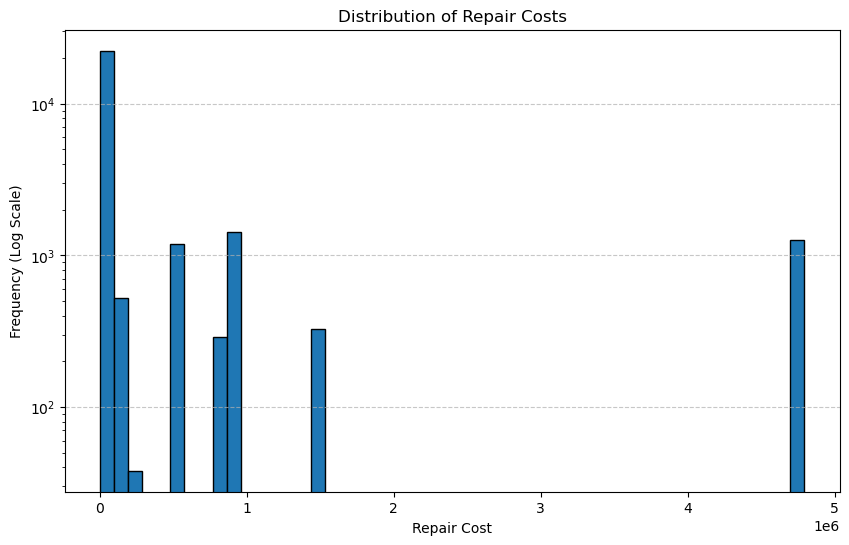

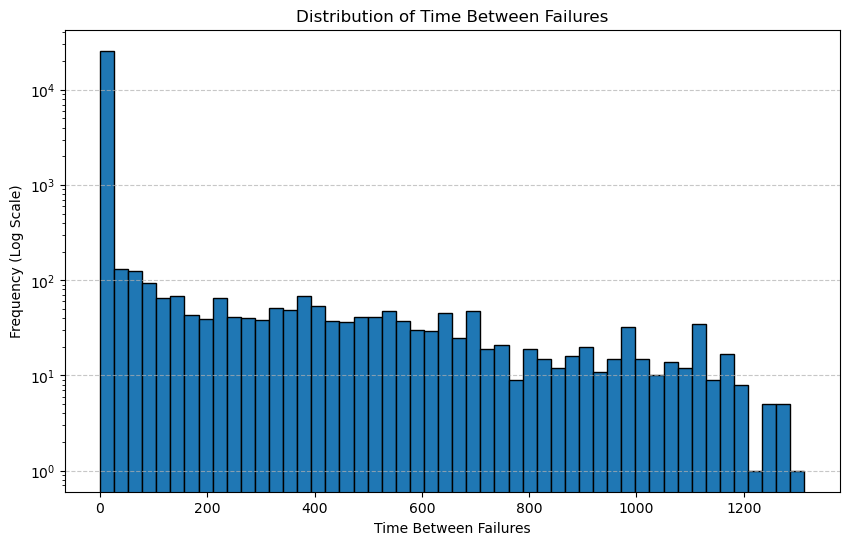

In [11]:
# Plot distribution of repair costs
plt.figure(figsize=(10, 6))
plt.hist(dataset['COSTO'], bins=50, edgecolor='black', log=True)
plt.title('Distribution of Repair Costs')
plt.xlabel('Repair Cost')
plt.ylabel('Frequency (Log Scale)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot distribution of time between failures
plt.figure(figsize=(10, 6))
plt.hist(dataset['TIEMPO_ENTRE_EQUIPO_FALLO'], bins=50, edgecolor='black', log=True)
plt.title('Distribution of Time Between Failures')
plt.xlabel('Time Between Failures')
plt.ylabel('Frequency (Log Scale)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Repair Costs Distribution:
- The histogram of repair costs (`COSTO`) shows a heavily right-skewed distribution.
- Most repairs are inexpensive, but there are a few outliers with extremely high costs. This suggests that while routine repairs dominate, certain exceptional cases significantly increase costs.

### Time Between Failures Distribution:
- The histogram of the time between equipment failures (`TIEMPO_ENTRE_EQUIPO_FALLO`) also shows a skewed distribution.
- A majority of machines experience failures within short intervals, while fewer machines have long operational periods without failure.


## Data Preprocessing

In [32]:
dataset["CLASS"] = np.where(dataset['COSTO'] >= 60000, 1, 0)

In [38]:
# Export file

# Export to CSV with options
dataset.to_csv(
    'parts_wrangled.csv',       # File name
    index=False,        # Exclude the index column
    encoding='utf-8',   # Encoding type (default is utf-8)
    sep=',',            # Separator (default is comma)
    header=True,        # Include column headers
)